# Includes

In [2]:
from commonfunctions import *
import cv2
import os
import sys
import tkinter as tk
from PIL import Image, ImageTk
from collections import defaultdict
from scipy import stats


## Face Detection

In [3]:
def detectFace(frame):
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    # face = face_classifier.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
    face = face_classifier.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=5)
    
    # Draw a rectangle around the faces (Used for testing purposes)
    # for (x, y, w, h) in face:
    #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 4)
    return face

## Left Pipeline
- Gray Conversion
- Noise Removal
- Edge Detection
- Dilation

### Gray Conversion

In [4]:
def grayConversion(frame):
    # conversion of BGR to grayscale is necessary to apply this operation
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return gray

### Sharpening

In [5]:
def sharpen(frame):
    # sharpening the image
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(frame, -1, kernel)
    return sharpened

    # # gaussian filter
    # blur = cv2.GaussianBlur(frame, (5,5), 0)
    # # unsharp masking
    # sharpened = cv2.addWeighted(frame, 1.5, blur, -0.5, 0)
    # return sharpened


### Noise Removal

In [6]:
def noiseRemoval(frame):
    # noise removal using median filter
    median = cv2.medianBlur(frame, 11)
    # gaussian
    blur = cv2.GaussianBlur(median, (3,3), 0)
    return blur

### Edge Detection

In [7]:
# canny edge detector
def cannyDetector(frame):
    # canny = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    # canny edge detector
    canny = cv2.Canny(frame, 150, 190)
    return canny 


### Dilation

In [8]:
# dilation
def dilation(frame):
    # dilation
    kernel = np.ones((2, 2), np.uint8)
    dilation = cv2.dilate(frame, kernel, iterations=1)
    
    return dilation

### Color Conversion

In [9]:
def colorConversion(frame):
    # conversion of GRAY to BGR
    BGR = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    return BGR

In [10]:
def leftPipeline(frame, detectFaceMode = False):
    gray        = grayConversion(frame)
    denoised    = noiseRemoval(gray)
    sharpened   = sharpen(denoised)
    canny       = cannyDetector(sharpened)
    dilated = canny
    if not detectFaceMode:
        dilated     = dilation(canny)
    # BGR         = colorConversion(dilated)
    dilated = 255 - dilated
    return dilated

## Right Pipeline
- Separating RGB Channels
- Average Filtering
- Color Quantization
- Combining RGB Channels

### Separating RGB channels

In [11]:
def separateRGB(frame):
    # separate the RGB channels
    b, g, r = cv2.split(frame)
    return b, g, r

### Average Filtering

In [12]:
def averageFilter(b, g, r):
    # average filter
    b = cv2.blur(b, (5,5))
    g = cv2.blur(g, (5,5))
    r = cv2.blur(r, (5,5))
    return b, g, r

### Color Quantization
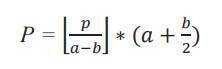

In [13]:
def quantize(b, g, r):
    x = 200
    y = 180
    
    # quantize the image
    b = np.uint8(b/(x - y))*(x + (y // 2))
    g = np.uint8(g/(x - y))*(x + (y // 2))
    r = np.uint8(r/(x - y))*(x + (y // 2))

    # normalize
    b = np.uint8(b/np.max(b)*255)
    g = np.uint8(g/np.max(g)*255)
    r = np.uint8(r/np.max(r)*255)

    return b, g, r

In [14]:
def KmeansQuantize(b, g, r):
    # convert to RGB
    # frame_RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Reshape image to an Mx3 array
    # img = frame_RGB.reshape(-1,3)
    img_b = b.reshape(-1,1)
    img_g = g.reshape(-1,1)
    img_r = r.reshape(-1,1)

    # print(len(np.unique(img, axis=0)), 'unique RGB values out of', img.shape[0], 'pixels')

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 4
    compactness_b, labels_b, centers_b = cv2.kmeans(data = img_b.astype(np.float32), K = K, bestLabels = None, criteria = criteria, attempts = 10, flags = cv2.KMEANS_RANDOM_CENTERS)
    compactness_g, labels_g, centers_g = cv2.kmeans(data = img_g.astype(np.float32), K = K, bestLabels = None, criteria = criteria, attempts = 10, flags = cv2.KMEANS_RANDOM_CENTERS)
    compactness_r, labels_r, centers_r = cv2.kmeans(data = img_r.astype(np.float32), K = K, bestLabels = None, criteria = criteria, attempts = 10, flags = cv2.KMEANS_RANDOM_CENTERS)

    # colours = centers[labels].reshape(-1,3)
    colours_b = centers_b[labels_b].reshape(-1,1)
    colours_g = centers_g[labels_g].reshape(-1,1)
    colours_r = centers_r[labels_r].reshape(-1,1)

    # print(len(np.unique(colours, axis=0)), 'unique RGB values out of', colours.shape[0], 'pixels')

    img_colours_b = colours_b.reshape(b.shape)
    img_colours_g = colours_g.reshape(g.shape)
    img_colours_r = colours_r.reshape(r.shape)
    
    return img_colours_b, img_colours_g, img_colours_r

### Combining RGB Channels

In [15]:
def combine(b, g, r):
    # combine the channels
    combined = cv2.merge((b, g, r))
    return combined

In [16]:
def rightPipeline(frame, detectFaceMode = False):
    b, g, r = separateRGB(frame)
    b, g, r = averageFilter(b, g, r)
    
    if detectFaceMode:
        b, g, r = KmeansQuantize(b, g, r)
    else:
        b, g, r = quantize(b, g, r)
    
    combined = combine(b, g, r)
    
    return combined

In [17]:
# def rightPipelineFace(frame):
#     b, g, r = separateRGB(frame)
#     b, g, r = averageFilter(b, g, r)
#     # b, g, r = quantize(b, g, r)
#     b, g, r = KmeansQuantize(b, g, r)
#     combined = combine(b, g, r)
    
#     return combined

### Reading the video frame by frame

In [18]:
# Creating a VideoCapture object to read the video

# cap = cv2.VideoCapture('data/Succession-Season-1-1080.mp4')

# detectFaceMode = True           # Flag for face detection mode



def VideoCartoonizer(detectFaceMode = False):
    frameCounter = 0                # Counter for face detection mode
    skipFrames = 10                 # number of frames to skip before detecting faces again
    faces = []                      # List of faces detected in the frame
    videos = os.listdir("data/Videos/")
    cap = cv2.VideoCapture("data/Videos/" + videos[1])
    try:
        # Loop until the end of the video
        while (cap.isOpened()):
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:     # If there is no frame to read, i.e. end of video
                break

            # resize the frame
            frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
                                interpolation = cv2.INTER_CUBIC)

            leftPipe = leftPipeline(frame, detectFaceMode)          # The left pipeline is applied regardless of the face detection mode

            # Check for face detection mode
            if detectFaceMode:      # Face detection mode - Cartoonize only the face
                # This ensures that regions outside ROI remain unchanged
                rightPipe = frame.copy()            
                combined = frame.copy()
                
                if frameCounter % skipFrames == 0:     # Reset the counter
                    faces = detectFace(frame)
                    frameCounter = 0    

                # Loop over the ROI and apply the right pipeline
                for face in faces:
                    x, y, w, h = face

                    # leftPipe[y : y+h, x : x+w] = leftPipeline(frame[y : y+h, x : x+w])
                    rightPipe[y : y+h, x : x+w] = rightPipeline(frame[y : y+h, x : x+w], detectFaceMode)
                    # Now, we combine only the ROI of the frame
                    combined[y : y+h, x : x+w] = cv2.bitwise_and(rightPipe[y : y+h, x : x+w], rightPipe[y : y+h, x : x+w], mask=leftPipe[y : y+h, x : x+w])
                
                
                frameCounter += 1

            else:       # Normal mode - Cartoonize the whole frame
                leftPipe = leftPipeline(frame, detectFaceMode)
                rightPipe = rightPipeline(frame, detectFaceMode)
                combined = cv2.bitwise_and(rightPipe, rightPipe, mask=leftPipe)

            
            cv2.imshow('Frame', frame)                  # Display the original frame
            cv2.imshow('left', leftPipe)                # Display the left pipeline result
            cv2.imshow('right', rightPipe)              # Display the right pipeline result
            cv2.imshow('da5alo f ba3d', combined)       # Display the combined image

            
            # define q as the exit button
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            
    except Exception as e:
        # Throw the exception after releasing the video capture object
        cap.release()
        cv2.destroyAllWindows()
        raise e
        # kda msh bn7tag n3ml restart lel kernel m3 kol error
    
    # release the video capture object
    cap.release()
    # Closes all the windows currently opened.
    cv2.destroyAllWindows()

### Photo Testing

In [19]:
# os.listdir("data/Photos/")
def TestPhotos(detectFaceMode = False):
    cap = cv2.VideoCapture('data/Succession-Season-1-1080.mp4')
    for photo in os.listdir("data/Photos/"):
        frame = cv2.imread("data/Photos/"+photo, cv2.IMREAD_COLOR)

        frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
                            interpolation = cv2.INTER_CUBIC)
        

        
        leftPipe = leftPipeline(frame, detectFaceMode)          # The left pipeline is applied regardless of the face detection mode

        # Check for face detection mode
        if detectFaceMode:      # Face detection mode - Cartoonize only the face
            # This ensures that regions outside ROI remain unchanged
            rightPipe = frame.copy()            
            combined = frame.copy()
            
            faces = detectFace(frame)
            
            # Loop over the ROI and apply the right pipeline
            for face in faces:
                x, y, w, h = face
                rightPipe[y : y+h, x : x+w] = rightPipeline(frame[y : y+h, x : x+w], detectFaceMode)
                # Now, we combine only the ROI of the frame
                combined[y : y+h, x : x+w] = cv2.bitwise_and(rightPipe[y : y+h, x : x+w], rightPipe[y : y+h, x : x+w], mask=leftPipe[y : y+h, x : x+w])

        else:
            leftPipe = leftPipeline(frame, detectFaceMode)
            rightPipe = rightPipeline(frame, detectFaceMode)
            combined = cv2.bitwise_and(rightPipe, rightPipe, mask=leftPipe)
        
        
        cv2.imshow('Frame', frame)                  # Display the original frame
        cv2.imshow('left', leftPipe)                # Display the left pipeline result
        cv2.imshow('right', rightPipe)              # Display the right pipeline result
        cv2.imshow('da5alo f ba3d', combined)       # Display the combined image
        
        # define q as the exit button
        while True:
            key = cv2.waitKey(25)
            if key & 0xFF == ord('q'):
                break
            elif key & 0xFF == ord('e'):
                # release the video capture object
                cap.release()
                # Closes all the windows currently opened.
                cv2.destroyAllWindows()
                # sys.exit()
                return
    
    # release the video capture object
    cap.release()
    # Closes all the windows currently opened.
    cv2.destroyAllWindows()

In [20]:
detectFaceMode = False
TestPhotos(detectFaceMode)

In [21]:
# cap = cv2.VideoCapture('data/Succession-Season-1-1080.mp4')
# frame = cv2.imread("test1.jpg", cv2.IMREAD_COLOR)

# frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
#                     interpolation = cv2.INTER_CUBIC)

# # Display the resulting frame
# cv2.imshow('Frame', frame)

# # conversion of BGR to grayscale is necessary to apply this operation
# leftPipe = leftPipeline(frame)          # The left pipeline is applied regardless of the face detection mode

# # Check for face detection mode
# if detectFaceMode:      # Face detection mode - Cartoonize only the face
#     # This ensures that regions outside ROI remain unchanged
#     rightPipe = frame.copy()            
#     combined = frame.copy()
    
#     faces = detectFace(frame)
    
#     # Loop over the ROI and apply the right pipeline
#     for face in faces:
#         x, y, w, h = face
#         rightPipe[y : y+h, x : x+w] = rightPipeline(frame[y : y+h, x : x+w])
#         # Now, we combine only the ROI of the frame
#         combined[y : y+h, x : x+w] = cv2.bitwise_and(rightPipe[y : y+h, x : x+w], rightPipe[y : y+h, x : x+w], mask=leftPipe[y : y+h, x : x+w])

# else:
#     leftPipe = leftPipeline(frame)
#     rightPipe = rightPipeline(frame)
#     combined = cv2.bitwise_and(rightPipe, rightPipe, mask=leftPipe)


# cv2.imshow('Frame', frame)                  # Display the original frame
# cv2.imshow('left', leftPipe)                # Display the left pipeline result
# cv2.imshow('right', rightPipe)              # Display the right pipeline result
# cv2.imshow('da5alo f ba3d', combined)       # Display the combined image

# # define q as the exit button
# while True:
#     key = cv2.waitKey(25)
#     if key & 0xFF == ord('q'):
#         break
#     elif key & 0xFF == ord('e'):
#         # release the video capture object
#         cap.release()
#         # Closes all the windows currently opened.
#         cv2.destroyAllWindows()
#         sys.exit()
#         # return

# # release the video capture object
# cap.release()
# # Closes all the windows currently opened.
# cv2.destroyAllWindows()

# GUI

In [22]:
class MyGUI:

    def __init__(self):
        self.main_window = tk.Tk()
        self.main_window.geometry('500x300')
        self.main_window.title('Cartoonizer')
        
        img = ImageTk.PhotoImage(Image.open("BackGS.png"))
        self.panel = tk.Label(image = img)
        self.panel.place(x=0, y=0, relwidth=1, relheight=1)
        self.check_state = tk.IntVar()
        
        # write welcome at top of screen
        
        self.welcome_label = tk.Label(self.main_window, text='Welcome to our Cartoonizer', font=('Callibri', 25 ), bg='#000836', fg='white')
        self.welcome_label.pack(side='top')
        
        
        self.check_state = tk.IntVar()
        
        self.cartoonize_option = tk.Checkbutton(self.main_window, text='Cartoonize Face Only',font=('Callibri', 16 ), variable=self.check_state, onvalue=1, offvalue=0)    
        self.cartoonize_option.configure(bg='pink')
        self.cartoonize_option.configure(fg='#000836')
        self.cartoonize_option.configure(activebackground='#ffcdd6')
        self.cartoonize_option.pack(side='top', pady=25)
        
        self.start_cartoonize_button = tk.Button(self.main_window, text='Start Photo Cartoonization', command=self.get_cartoonize_option)
        self.start_cartoonize_button.configure(bg='pink')
        self.start_cartoonize_button.configure(fg='#000836')
        self.start_cartoonize_button.pack(pady=10)

        self.start_cartoonize_button_video = tk.Button(self.main_window, text='Start Video Cartoonization', command=self.get_cartoonize_option_video)
        self.start_cartoonize_button_video.configure(bg='pink')
        self.start_cartoonize_button_video.configure(fg='#000836')
        self.start_cartoonize_button_video.pack(pady=10)
        
        self.quit_button = tk.Button(self.main_window, text='Quit', command=self.main_window.destroy)
        
        self.quit_button.configure(bg='pink')
        self.quit_button.configure(fg='#000836')
        self.quit_button.pack(side='bottom', pady=10)

        
        self.main_window.mainloop()
        
    def get_cartoonize_option(self):
        
        TestPhotos(self.check_state.get())
    
    def get_cartoonize_option_video(self):
        
        VideoCartoonizer(self.check_state.get())
    
        
MyGUI()

0 03-shutterstock_97696616.png
1 Abood.jpg
2 american-house.jpg
3 cat.jpg
4 Farah1.jpeg
5 Farah3.jpeg
6 IMG_6621.jpg
7 IMG_6816.jpg
8 Mount-Fuji-New.jpg
9 original2.jpg


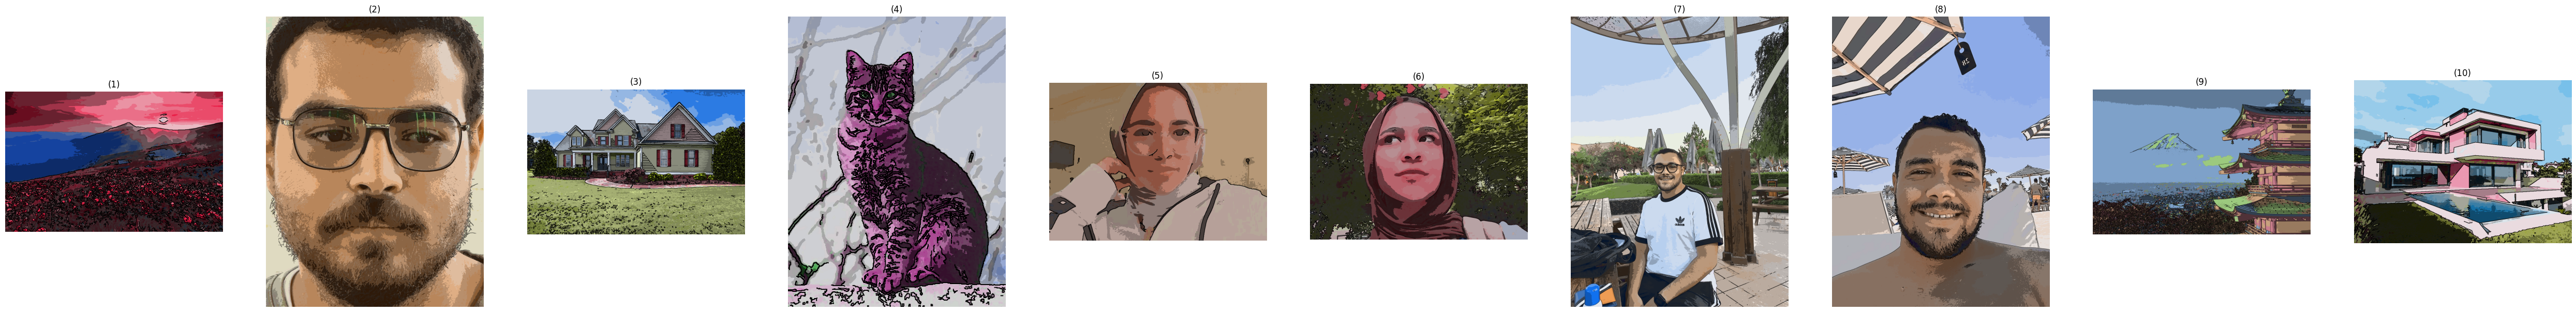

In [33]:
def update_c(C,hist):
    while True:
        groups=defaultdict(list)

        for i in range(len(hist)):
            if(hist[i] == 0):
                continue
            d=np.abs(C-i)
            index=np.argmin(d)
            groups[index].append(i)

        new_C=np.array(C)
        for i,indice in groups.items():
            if(np.sum(hist[indice])==0):
                continue
            new_C[i]=int(np.sum(indice*hist[indice])/np.sum(hist[indice]))

        if(np.sum(new_C-C)==0):
            break
        C=new_C

    return C,groups

# Calculates K Means clustering
def K_histogram(hist):

    alpha=0.001
    N=80
    C=np.array([128])

    while True:
        C,groups=update_c(C,hist)

        new_C=set()
        for i,indice in groups.items():
            if(len(indice)<N):
                new_C.add(C[i])
                continue

            z, pval=stats.normaltest(hist[indice])
            if(pval<alpha):
                left=0 if i==0 else C[i-1]
                right=len(hist)-1 if i ==len(C)-1 else C[i+1]
                delta=right-left
                if(delta >=3):
                    c1=(C[i]+left)/2
                    c2=(C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    new_C.add(C[i])
            else:
                new_C.add(C[i])
        if(len(new_C)==len(C)):
            break
        else:
            C=np.array(sorted(new_C))
    return C

# The main controlling function
def caart(img):

    kernel=np.ones((2,2), np.uint8)
    output=np.array(img)
    x,y,c=output.shape
    for i in range(c):
        output[:,:,i]=cv2.bilateralFilter(output[:,:,i],5,150,150)

    edge=cv2.Canny(output, 100, 200)
    output=cv2.cvtColor(output,cv2.COLOR_RGB2HSV)

    hists = []

    hist,_=np.histogram(output[:,:,0],bins =np.arange(180+1))
    hists.append(hist)
    hist,_=np.histogram(output[:,:,1],bins =np.arange(256+1))
    hists.append(hist)
    hist,_=np.histogram(output[:,:,2],bins =np.arange(256+1))
    hists.append(hist)


    C=[]
    for h in hists:
        C.append(K_histogram(h))
    #print("centroids: {0}".format(C))

    output=output.reshape((-1,c))
    for i in range(c):
        channel=output[:,i]
        index=np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:,i]=C[i][index]
    output=output.reshape((x,y,c))
    output=cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    contours,_=cv2.findContours(edge,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(output,contours,-1,0,thickness=1)
    #cartoon = cv2.bitwise_and(output, output, mask=contours)
    for i in range(3):
        output[:,:,i]=cv2.erode(output[:,:,i], kernel, iterations=1)
    #Laplacian = cv2.Laplacian(output,cv2.CV_8U, ksize=11)
    #output=output-Laplacian
    return output

        
photos = os.listdir("data/Photos/")
images = []
for i, photo in enumerate(photos):
    print(i, photo)
    output=caart(cv2.imread("data/Photos/" + photo))
    # cv2.imwrite("cartoon" + str(i) + ".jpg", output)
    # convert BGR to RGB
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    images.append(output)
    # io.imshow(output)
show_images([*images])

# output=caart(cv2.imread("data/Photos/" + photos[1]))
# # cv2.imwrite("cartoon.jpg", output)
# # convert BGR to RGB
# output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
# io.imshow(output)
# # cv2.imshow('Frame', output)                  # Display the original frame